In [9]:
%matplotlib inline
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns
sns.set(style='white', context='notebook', palette="muted")

D:\Anaconda3\envs\py35\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [15]:
def plot_matrix(M, cmap='viridis', norm=mpl.colors.LogNorm()):
    plt.matshow(M, cmap=cmap, norm=norm)
    plt.xticks([])
    plt.yticks([])

# Efficient evolutionary simulations

## NumPy

In [16]:
L = 50  # number of genes
N = 1000000  # population size
U = 1e-4  # mutation rate
s = 0.01  # selection coefficient

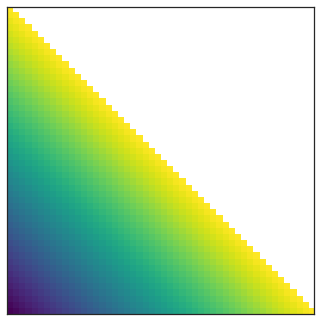

In [17]:
def mutation_matrix(N, U, s, L):
    rv = st.poisson(U)
    m = rv.pmf(np.arange(L))
    M = np.zeros((L, L))
    for i in range(L):
        M[i:, i] = m[:L-i]
    for i in range(-L + 1, L):
        assert (M.diagonal(i) == M.diagonal(i)[0]).all()
    M[np.diag_indices(L)] += 1 - M.sum(axis=0)
    assert (M.sum(axis=0) == 1).all()
    return M

M = mutation_matrix(N, U, s, L)
plot_matrix(M)

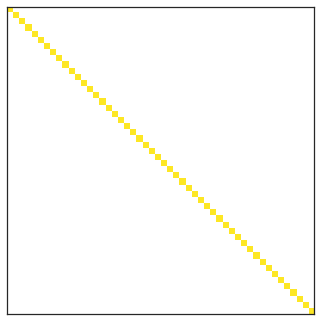

In [18]:
def selection_matrix(N, U, s, L):
    w = (1 - s)**np.arange(L)
    S = np.diag(w)
    return S

S = selection_matrix(N, U, s, L)
plot_matrix(S)

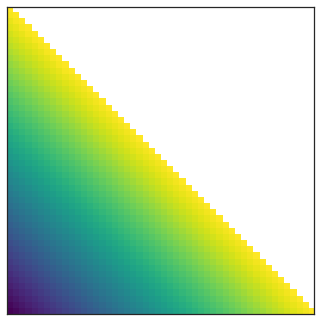

In [19]:
E = M @ S
assert E.shape == (L, L)
plot_matrix(E)

In [20]:
def simulation(N, U, s, L, generations=1000):
    M = mutation_matrix(N, U, s, L)
    S = selection_matrix(N, U, s, L)
    E = M @ S

    # population frequency vector vs time
    p = np.empty((L, generations), dtype=float)
    p[:, 0] = 0
    p[0, 0] = 1
    # mean fitness vs time
    W = np.empty(generations, dtype=float)
    W[0] = S.diagonal() @ p[:, 0]

    for t in range(1, generations):
        # mutation and selection
        p[:, t] = E @ p[:, t-1]
        p[:, t] /= p[:, t].sum()
        # drift
        if  N > 0:
            p[:, t] = np.random.multinomial(N, p[:, t]) / N
        # calculate mean fitness
        W[t] = S.diagonal() @ p[:, t]
    return p, W

p, W = simulation(N, U, s, L, generations=1000)

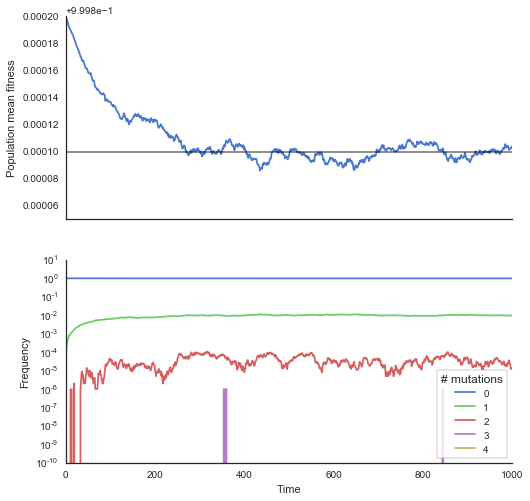

In [21]:
def simulation_plot(N, U, s, L, p, W, max_genotype=5):
    fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
    ax[0].plot(W)
    ax[0].axhline(1-U, color='k', alpha=0.5)
    ax[0].set(
        ylabel='Population mean fitness',
        ylim=(1 - 1.5 * U, 1)
    )
    
    ax[1].plot(p[:max_genotype,:].T);
    ax[1].set(
        yscale='log',
        ylim=(1e-10, 10),
        xlabel='Time',
        ylabel='Frequency'
    )
    ax[1].legend(np.arange(max_genotype), title='# mutations', loc='lower right', frameon=True, framealpha=0.8)

    
    sns.despine()
    return fig, ax

simulation_plot(N, U, s, L, p, W);

In [133]:
%timeit simulation(1000000, U, s, 100, generations=10000)
%timeit simulation(10000000, U, s, 100, generations=10000)
%timeit simulation(100000000, U, s, 100, generations=10000)

1 loop, best of 3: 835 ms per loop
1 loop, best of 3: 818 ms per loop
1 loop, best of 3: 813 ms per loop


In [135]:
%timeit -n 1 -r 3 simulation(10000000, U, s, 1000, generations=10000)

1 loop, best of 3: 11.7 s per loop


A larger value of L - 10,000 - doesn't work, as the generated matrix is too big.

In [16]:
M = mutation_matrix(N, U, s, 1000)
print("Size of M: {:.2f} MB".format(sys.getsizeof(M) / 1000000))

Size of M: 8.00 MB


In [17]:
M = mutation_matrix(N, U, s, 10000)
print("Size of M: {:.2f} MB".format(sys.getsizeof(M) / 1000000))

Size of M: 800.00 MB


In [35]:
M = mutation_matrix(N, U, s, 20000)
print("Size of M: {:.2f} MB".format(sys.getsizeof(M) / 1000000))

Size of M: 3200.00 MB


In [36]:
del M
del p
del W
del E
del S

## Dask

https://github.com/dask/dask-tutorial/blob/master/01-Array.ipynb

In [22]:
import dask.array as da

In [45]:
M = mutation_matrix(N, U, s, 10000)
print("Size of M: {:.2f} MB".format(sys.getsizeof(M) / 1000000))
Md = da.from_array(M, chunks=(1000, 1000))

Size of M: 800.00 MB


In [46]:
print("Size of M: {:.2f} MB".format(sys.getsizeof(M) / 1000000))
print("Size of M: {:.2f} MB".format(sys.getsizeof(Md) / 1000000))

Size of M: 800.00 MB
Size of M: 0.00 MB


In [47]:
%timeit (M.sum(axis=0) == 1).all()
%timeit (Md.sum(axis=0) == 1).all().compute()

10 loops, best of 3: 130 ms per loop
10 loops, best of 3: 169 ms per loop


In [119]:
from dask.utils import different_seeds
from itertools import product
from dask.base import tokenize
Array = da.Array
normalize_chunks = da.core.normalize_chunks

def _apply_random(func, seed, size, args, kwargs):
    """ Apply RandomState method with seed
    >>> _apply_random('normal', 123, 3, (10, 1.0), {})
    array([  8.9143694 ,  10.99734545,  10.2829785 ])
    """
    state = np.random.RandomState(seed)
    func = getattr(state, func)
    return func(*args, size=size, **kwargs)

class RandomState(object):
   
    def __init__(self, seed=None):
        self._numpy_state = np.random.RandomState(seed)

    def seed(self, seed=None):
        self._numpy_state.seed(seed)

    def _wrap(self, func, *args, **kwargs):
        size = kwargs.pop('size')
        chunks = kwargs.pop('chunks')

        if not isinstance(size, (tuple, list)):
            size = (size,)

        chunks = normalize_chunks(chunks, size)

        # Get dtype
        kw = kwargs.copy()
        kw['size'] = (0,)
        dtype = func(np.random.RandomState(), *args, **kw).dtype

        # Build graph
        sizes = list(product(*chunks))
        seeds = different_seeds(len(sizes), self._numpy_state)
        token = tokenize(seeds, size, chunks, args, kwargs)
        name = 'da.random.{0}-{1}'.format(func.__name__, token)
        keys = product([name], *[range(len(bd)) for bd in chunks])
        vals = ((_apply_random, func.__name__, seed, size, args, kwargs)
                for seed, size in zip(seeds, sizes))
        dsk = dict(zip(keys, vals))

        return Array(dsk, name, chunks, dtype=dtype)

    def multinomial(self, n, p, size=1, chunks=None):
        return self._wrap(np.random.RandomState.multinomial, n, p,
                         size=size, chunks=chunks)

In [120]:
rs = RandomState()
p = np.array([1/10000]*10000)
x = rs.multinomial(100, p, chunks=(1000,))

In [121]:
x.sum(axis=1).compute()

array([100])

In [23]:
L = 50  # number of genes
N = 1000000  # population size
U = 1e-4  # mutation rate
s = 0.01  # selection coefficient

In [24]:
def simulation_da(N, U, s, L, generations=1000, chunk_size=100):
    print("Init...")
    M = da.from_array(mutation_matrix(N, U, s, L), chunks=(chunk_size, chunk_size))
    S = selection_matrix(N, U, s, L)
    w = da.from_array(S.diagonal(), chunks=(chunk_size,))
    S = da.from_array(S, chunks=(chunk_size, chunk_size))
    E = M.dot(S)

    # population frequency vector vs time    
    p = np.zeros(L)
    p[0] = 1
    p = da.from_array(p, chunks=(chunk_size,))   
                       
    # mean fitness vs time
    W = [None] * generations
    W[0] = w.dot(p)
    
    print("Start...")
    for t in range(1, generations):
        # mutation and selection
        p = E.dot(p)
        p /= p.sum()
        # drift
        if  N > 0:
            p = rs.multinomial(N, p, chunks=(chunk_size,)) / N            
        # calculate mean fitness
        W[t] = w.dot(p)
    print("Finished")
    return W

In [25]:
W = simulation_da(0, U, s, 50, generations=1000, chunk_size=10)
W_ = da.compute(*W)
plt.plot(W_);

Init...
Start...


KeyboardInterrupt: 

1 loop, best of 1: 153 ms per loop


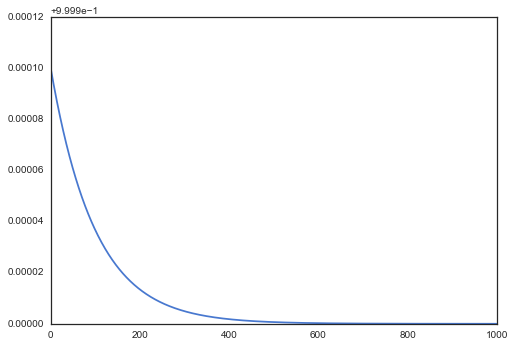

In [148]:
%%timeit -n 1 -r 1
W = simulation(0, U, s, 50, generations=1000)[1]
plt.plot(W);